In [3]:
%load_ext autoreload
%autoreload 2
import itertools
import math

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import clip
from transformers import BertTokenizer, BertModel

from src.data.diffusion_db_module import DiffusionDBModule
from src.models.transformer import TransformerImg2Prompt

/home/minhduc0711/miniconda3/envs/diffusion/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the pretrained models
clip_model, preprocess = clip.load("ViT-B/32")
# For some reason, the weights in the CLIP model are automatically converted
# to float16. We convert it back to float32
clip_model = clip_model.float()

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Load the dataset
dm = DiffusionDBModule(batch_size=4,
                       subset_name="large_first_1k",
                       img_transform=preprocess,
                       bert_tokenizer=bert_tokenizer)
dm.setup("train")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Found cached dataset diffusiondb (/home/minhduc0711/.cache/huggingface/datasets/poloclub___diffusiondb/large_first_1k/0.9.1/547894e3a57aa647ead68c9faf14832

In [6]:
# load trained model
model = TransformerImg2Prompt.load_from_checkpoint(
     "epoch=9-step=550-val_loss=0.178134.ckpt",
     clip_model=clip_model, bert_model=bert_model)

In [10]:
# predict on a very small test subset 
trainer = pl.Trainer()
test_ds = Subset(dm.diffusion_db_test, torch.arange(4))
loader = DataLoader(test_ds, batch_size=4)

predictions = trainer.predict(model, loader)[0]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/minhduc0711/miniconda3/envs/diffusion/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.91s/it]


Pred prompt:  [CLS] photograph street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street street
True prompt:  a photograph of a futuristic street scene, brutalist style, advertising signs, straight edges, finely detailed oil painting, impasto brush strokes, soft light, 8 k, dramatic composition, dramatic lighting, sharp focus, octane render, masterpiece, by adrian ghenie and jenny saville and zhang jingna 


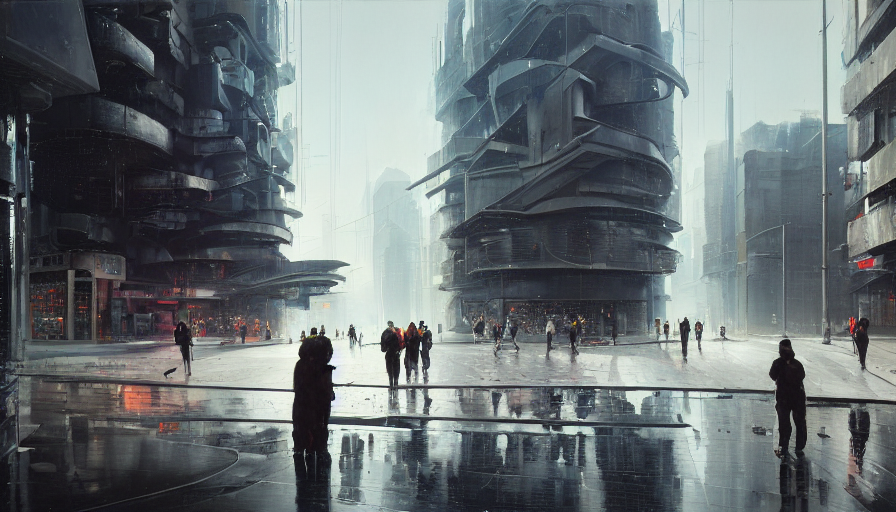

In [21]:
sample_idx = 0  # change this idx to see result for different images in the batch
global_idx = test_ds[sample_idx]["global_idx"]
hf_data_item = test_ds.dataset.dataset.hf_dataset[global_idx]

print("Pred prompt: ", bert_tokenizer.decode(predictions[sample_idx]))
print("True prompt: ", test_ds.dataset.dataset.hf_dataset[global_idx]['prompt'])

hf_data_item["image"]